### Classification of a dataset composed by 3 groups of 2D points

First of all we randomly generate 3 groups of datapoints that will constitute our training dataset.
The points are represented on the figure below

<class 'numpy.ndarray'>


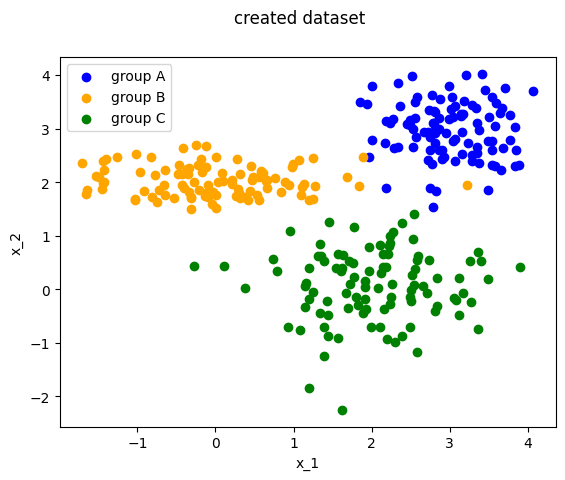

il y a au total : 60 mini tensors contenant chacun 5 echantillons


In [3]:
from GenerateData import GenerateData
from torch.utils.data import DataLoader

# get a homemade dataset
nb_points = 100                                                                                 # nb of generated points per group
train_ds = GenerateData(nb_points)

# utilisation du module DataLoader pour séparer le dataset en plusieurs morceaux (batch size)
# en fait train_dl sépare le tensor en plusieur tensor de bs lignes. train_dl est donc une liste de tensor 
bs = 5                                                                                          # batch size
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True) 
print(f'il y a au total : {len(train_dl)} mini tensors contenant chacun {bs} echantillons')




Now that we have the dataset we will construct the neural network

- Choice of the loss function, given that we are dealing with a classification problem we are going to choose a cross entropy loss function

In [5]:
import torch.nn.functional as F              # all the functions defined by torch

loss_fun = F.cross_entropy                   # combines nn.LogSoftmax() and nn.NLLLoss() in one single class. Therefore we shall not use Softmax in the output of neural network

- construction of the neural network

In [6]:
from torch import nn
import torch

class reseau_neurones(nn.Module):                # creation of the class "reseau_neuroness" which inherits from the nn.Module class 
    def __init__(self):
        super().__init__()                               # calling the constructor of the parent class
        self.couche1 = nn.Linear(2,10)                   # 10 neurones in the first layer with 2D data as inputs
        self.activation1 = nn.Tanh()
        self.couche2 = nn.Linear(10,5)                   # 5 neurones in the second layeur with 10D data as inputs
        self.activation2 = nn.Tanh()
        self.couche3 = nn.Linear(5,3)                    # 3 neurons in the last layer with 5D datas as inputs
        print(self.couche1.weight.dtype)
    
    ## taches réalisées lorsque la fonction "reseau_neurones" est appelée 
    def forward(self, xb):
        xb = xb.to(torch.float32)                       # Pytorch exige que les données d'entrées soient du même type que les éléments de la matrice weight
        output = self.couche1(xb)                       # sortie après passage des données au travers de la couche "couche1"
        output = self.activation1(output)
        output = self.couche2(output)
        output = self.activation2(output)
        output = self.couche3(output)
        return output


model = reseau_neurones()                       # instanciation d'un objet reseau de neurones
model.parameters


torch.float32


<bound method Module.parameters of reseau_neurones_1couche(
  (couche1): Linear(in_features=2, out_features=10, bias=True)
  (activation1): Tanh()
  (couche2): Linear(in_features=10, out_features=5, bias=True)
  (activation2): Tanh()
  (couche3): Linear(in_features=5, out_features=3, bias=True)
)>

- optimization of the neural network parameters. All the parameters of the neural network have been tracked automatically.

In [11]:
from torch import optim 
import numpy as np

alpha = 8e-5
optimizer = torch.optim.SGD(model.parameters(),lr = alpha)

nb_it = 10000                                                   # nb of iteration (nb of epochs)
cost = np.empty(nb_it)

for i in range(nb_it):                                          # for each iteration

    for xb,yb in train_dl:                                      # for each batch of the training dataset

        # forward step
        y_pred = model(xb)


        # loss computation
        yb = yb.flatten()                                       # yb must be 1D for Pytorch
        yb = yb.type(torch.LongTensor)                          # casting imposed by Pytorch, if not bug

        J = loss_fun(y_pred, yb)

        with torch.no_grad():                # disable the gradient computation tracking 
            cost[i] += J

        # compute the gradient
        J.backward()
        
        # optimize the gradient
        optimizer.step()

        # cleaning the gradient 
        optimizer.zero_grad()                       # same as model.zero_grad()                  

#print(cost)

- cleaning and plotting the cost function over iterations

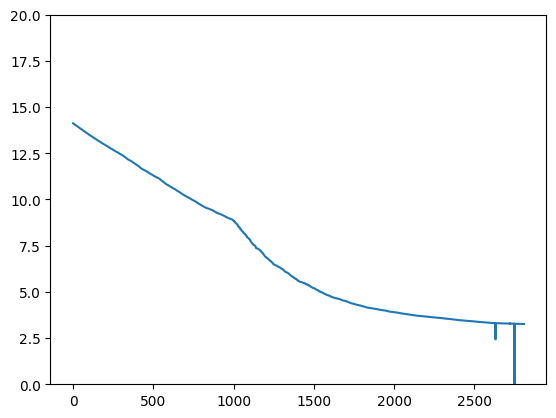

In [16]:
import matplotlib.pyplot as plt

## cleaning cost (removing extrem peaks), we remove all the value superior to the value of the cost at the initial stage
cost = cost[np.abs(cost)<cost[0]]


fig, ax = plt.subplots()
ax.plot(cost)
ax.set_ylim([0,20])                    # limites pour ne que les pics cachent tout
plt.show()

- plotting the training dataset and the contours associated with each outputs of the neural network

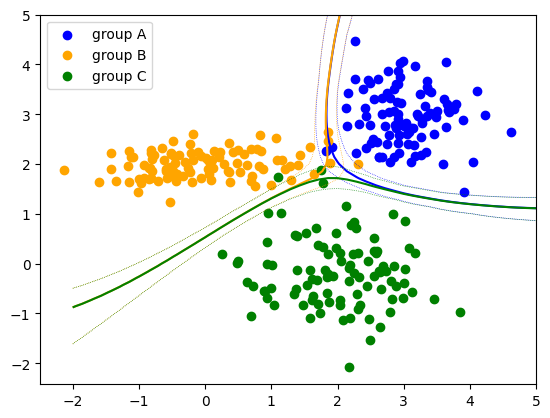

In [14]:


fig, ax = plt.subplots()

## plotting the 3 groups of point
nb_groups = 3
colors = ["blue","orange","green"]
labels = ["group A", "group B", "group C"]
for i in range(nb_groups):
    xb,yb  = train_ds[i*nb_points:i*nb_points + nb_points]
    plt.scatter(xb[:,0],xb[:,1], color= colors[i], label = labels[i])

## creating a grid
x1list = np.linspace(-2,5,50)
x2list = np.linspace(-2,5,50)
X1, X2 = np.meshgrid(x1list, x2list)
Z = np.empty((50,50))

for ind_group in range(nb_groups):                               # computing and plotting the contour for each group 
    with torch.no_grad():
        for i in range(50):
            for j in range(50):
                input = torch.tensor([X1[i,j],X2[i,j]])          # converting the grid point to a tensor 
                f = nn.Softmax(dim=0)                            # fonction to normalize the outputs, we choose the dim=0 because there is only one dim
                Z[i,j] = f(model(input))[ind_group]              # computing the neural network output for the given point

    ax.contour(X1,X2,Z,levels = [0.5], colors = colors[ind_group])
    ax.contour(X1,X2,Z,levels = [0.25, 0.75], colors = colors[ind_group], linewidths = 0.5, linestyles = 'dotted')
plt.legend()
plt.show()